In [1]:
import pandas as pd
import numpy as np
import glob
import re
import matplotlib as mpl
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns
from plotly.subplots import make_subplots
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
mpl.rcParams['figure.figsize'] = (8,6)
mpl.rcParams['axes.grid'] = False

### Importing Dataset

In [2]:
# first we are importing control group dataset
directory1 = 'C:/Users/Rizwan/Desktop/DDM/empathy/data/control_group'

#loading all the csv files
files_path1 = glob.glob(directory1 + "/*.csv")
all_dfss = []

for file in files_path1:
    df = pd.read_csv(file)
    all_dfss.append(df)

control_group = pd.concat(all_dfss, ignore_index=True)

print(control_group)


        Unnamed: 0  Recording timestamp  Computer timestamp       Sensor  \
0              672              4794663        613406823542          NaN   
1              673              4794663        613406823542          NaN   
2              674              4795431        613406824310  Eye Tracker   
3              675              4803692        613406832571  Eye Tracker   
4              676              4812026        613406840905  Eye Tracker   
...            ...                  ...                 ...          ...   
157045       31731             65940337       1666203561855          NaN   
157046       31732             65945534       1666203567052  Eye Tracker   
157047       31733             65953860       1666203575378  Eye Tracker   
157048       31734             65962157       1666203583675  Eye Tracker   
157049       31735             65970492       1666203592010  Eye Tracker   

           Project name Export date Participant name Recording name  \
0       Particip

In [3]:
control_group.shape

(157050, 71)

we have total 157050 rows and 71 columns

In [4]:
control_group.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 157050 entries, 0 to 157049
Data columns (total 71 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   Unnamed: 0                           157050 non-null  int64  
 1   Recording timestamp                  157050 non-null  int64  
 2   Computer timestamp                   157050 non-null  int64  
 3   Sensor                               156873 non-null  object 
 4   Project name                         157050 non-null  object 
 5   Export date                          157050 non-null  object 
 6   Participant name                     157050 non-null  object 
 7   Recording name                       157050 non-null  object 
 8   Recording date                       157050 non-null  object 
 9   Recording date UTC                   157050 non-null  object 
 10  Recording start time                 157050 non-null  object 
 11  Recording sta

In [5]:
control_group.describe()

,Unnamed: 0,Recording timestamp,Computer timestamp,Recording duration,Recording resolution height,Recording resolution width,Eyetracker timestamp,Gaze point X,Gaze point Y,Gaze point left X,...,Presented Media position X (DACSpx),Presented Media position Y (DACSpx),Original Media width,Original Media height,Gaze event duration,Eye movement type index,Fixation point X,Fixation point Y,Mouse position X,Mouse position Y
count,157050.000000,1.570500e+05,1.570500e+05,157050.000000,157050.0,157050.0,1.555730e+05,143736.000000,143736.000000,129702.000000,...,156795.000000,156795.000000,156795.000000,156795.000000,157044.000000,157044.000000,100376.000000,100376.000000,1300.000000,1300.000000
mean,19243.486660,5.178832e+07,1.584901e+12,96571.749863,1080.0,1920.0,1.349148e+09,918.325562,371.324908,843.603499,...,162.466571,-42.639319,925.034319,693.548417,258.855289,225.033500,916.493783,391.953325,-439.057692,799.160769
std,11042.943476,4.439866e+07,1.277341e+12,60902.872588,0.0,0.0,1.487618e+09,302.772212,249.596079,320.635144,...,211.506564,219.054603,607.108680,568.109513,312.269965,297.381821,270.934692,246.234219,91.996873,213.366926
min,650.000000,3.543312e+06,5.150226e+11,14124.000000,1080.0,1920.0,1.945353e+08,-167.000000,-216.000000,-363.000000,...,-747.000000,-1168.000000,640.000000,416.000000,8.000000,1.000000,0.000000,-212.000000,-734.000000,-59.000000
25%,9994.000000,2.285377e+07,6.134375e+11,64514.000000,1080.0,1920.0,3.952579e+08,750.000000,207.000000,648.000000,...,129.000000,0.000000,640.000000,416.000000,50.000000,70.000000,761.000000,233.000000,-474.000000,682.000000
50%,19138.500000,4.206347e+07,1.400260e+12,66391.000000,1080.0,1920.0,5.588218e+08,918.000000,355.000000,835.000000,...,129.000000,0.000000,798.000000,692.000000,183.000000,130.000000,919.000000,373.000000,-432.000000,872.500000
75%,27690.750000,6.051622e+07,1.666110e+12,90961.000000,1080.0,1920.0,1.179813e+09,1062.000000,522.000000,1003.000000,...,337.000000,0.000000,798.000000,692.000000,333.000000,241.000000,1047.000000,541.000000,-404.000000,971.000000
max,46554.000000,2.282859e+08,4.059247e+12,228445.000000,1080.0,1920.0,4.299671e+09,2302.000000,1156.000000,2302.000000,...,337.000000,0.000000,3415.000000,3415.000000,2500.000000,2132.000000,2287.000000,1123.000000,-192.000000,1023.000000


In [6]:
# creating a copy of control_group dataframe
df1 = control_group.copy()

In [7]:
df1.head()

,Unnamed: 0,Recording timestamp,Computer timestamp,Sensor,Project name,Export date,Participant name,Recording name,Recording date,Recording date UTC,...,Original Media height,Eye movement type,Gaze event duration,Eye movement type index,Fixation point X,Fixation point Y,Fixation point X (MCSnorm),Fixation point Y (MCSnorm),Mouse position X,Mouse position Y
0,672,4794663,613406823542,NaN,Participant0024,10.02.2021,Participant0024,Recording1,10.02.2021,10.02.2021,...,NaN,Unclassified,17.0,49.0,NaN,NaN,NaN,NaN,NaN,NaN
1,673,4794663,613406823542,NaN,Participant0024,10.02.2021,Participant0024,Recording1,10.02.2021,10.02.2021,...,NaN,Unclassified,17.0,49.0,NaN,NaN,NaN,NaN,NaN,NaN
2,674,4795431,613406824310,Eye Tracker,Participant0024,10.02.2021,Participant0024,Recording1,10.02.2021,10.02.2021,...,416.0,Unclassified,17.0,49.0,NaN,NaN,NaN,NaN,NaN,NaN
3,675,4803692,613406832571,Eye Tracker,Participant0024,10.02.2021,Participant0024,Recording1,10.02.2021,10.02.2021,...,416.0,Unclassified,17.0,49.0,NaN,NaN,NaN,NaN,NaN,NaN
4,676,4812026,613406840905,Eye Tracker,Participant0024,10.02.2021,Participant0024,Recording1,10.02.2021,10.02.2021,...,416.0,EyesNotFound,8.0,40.0,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
## converting all the datatypes with the actual data types


# Converting these columns into datetime their unit are milisecond
ml_date_cols = ['Recording timestamp', 'Computer timestamp', 'Recording duration', 'Eyetracker timestamp']

for col in ml_date_cols:
    df1[col] = pd.to_datetime(df1[col], unit='ms')


# Converting these columns into datetime 
date_cols = ['Export date', 'Recording date', 'Recording date UTC', 'Recording start time', 'Recording start time UTC']

for col in date_cols:
    df1[col] = pd.to_datetime(df1[col])


# Converting these columns into float and replace the (,) with the decimal point (.)

split_cols = ['Gaze direction left X','Gaze direction left Y','Gaze direction left Z','Gaze direction right X','Gaze direction right Y','Gaze direction right Z',
           'Pupil diameter left','Pupil diameter right','Eye position left X (DACSmm)','Eye position left Y (DACSmm)','Eye position left Z (DACSmm)',
           'Eye position right X (DACSmm)','Eye position right Y (DACSmm)','Eye position right Z (DACSmm)','Gaze point left X (DACSmm)',
           'Gaze point left Y (DACSmm)','Gaze point right X (DACSmm)','Gaze point right Y (DACSmm)','Gaze point X (MCSnorm)','Gaze point Y (MCSnorm)',
           'Gaze point left X (MCSnorm)','Gaze point left Y (MCSnorm)','Gaze point right X (MCSnorm)','Gaze point right Y (MCSnorm)',
           'Fixation point X (MCSnorm)','Fixation point Y (MCSnorm)'
       ]

for column in split_cols:
    df1[column] =df1[column].str.replace(',', '.').astype(float)
    

C:\Users\Rizwan\AppData\Local\Temp\ipykernel_8520\3338033060.py:15: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  df1[col] = pd.to_datetime(df1[col])
C:\Users\Rizwan\AppData\Local\Temp\ipykernel_8520\3338033060.py:15: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  df1[col] = pd.to_datetime(df1[col])
C:\Users\Rizwan\AppData\Local\Temp\ipykernel_8520\3338033060.py:15: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  df1[col] = pd.to_datetime(df1[col])


In [9]:
df1.head()

,Unnamed: 0,Recording timestamp,Computer timestamp,Sensor,Project name,Export date,Participant name,Recording name,Recording date,Recording date UTC,...,Original Media height,Eye movement type,Gaze event duration,Eye movement type index,Fixation point X,Fixation point Y,Fixation point X (MCSnorm),Fixation point Y (MCSnorm),Mouse position X,Mouse position Y
0,672,1970-01-01 01:19:54.663,1989-06-09 14:47:03.542,NaN,Participant0024,2021-10-02,Participant0024,Recording1,2021-10-02,2021-10-02,...,NaN,Unclassified,17.0,49.0,NaN,NaN,NaN,NaN,NaN,NaN
1,673,1970-01-01 01:19:54.663,1989-06-09 14:47:03.542,NaN,Participant0024,2021-10-02,Participant0024,Recording1,2021-10-02,2021-10-02,...,NaN,Unclassified,17.0,49.0,NaN,NaN,NaN,NaN,NaN,NaN
2,674,1970-01-01 01:19:55.431,1989-06-09 14:47:04.310,Eye Tracker,Participant0024,2021-10-02,Participant0024,Recording1,2021-10-02,2021-10-02,...,416.0,Unclassified,17.0,49.0,NaN,NaN,NaN,NaN,NaN,NaN
3,675,1970-01-01 01:20:03.692,1989-06-09 14:47:12.571,Eye Tracker,Participant0024,2021-10-02,Participant0024,Recording1,2021-10-02,2021-10-02,...,416.0,Unclassified,17.0,49.0,NaN,NaN,NaN,NaN,NaN,NaN
4,676,1970-01-01 01:20:12.026,1989-06-09 14:47:20.905,Eye Tracker,Participant0024,2021-10-02,Participant0024,Recording1,2021-10-02,2021-10-02,...,416.0,EyesNotFound,8.0,40.0,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 157050 entries, 0 to 157049
Data columns (total 71 columns):
 #   Column                               Non-Null Count   Dtype         
---  ------                               --------------   -----         
 0   Unnamed: 0                           157050 non-null  int64         
 1   Recording timestamp                  157050 non-null  datetime64[ns]
 2   Computer timestamp                   157050 non-null  datetime64[ns]
 3   Sensor                               156873 non-null  object        
 4   Project name                         157050 non-null  object        
 5   Export date                          157050 non-null  datetime64[ns]
 6   Participant name                     157050 non-null  object        
 7   Recording name                       157050 non-null  object        
 8   Recording date                       157050 non-null  datetime64[ns]
 9   Recording date UTC                   157050 non-null  datetime64[ns]
 

all data types are converted to their respective data Because this is the tie series dataset so we need to set the index to Recording timestamp

In [11]:
# Set the index to Recording timestamp because this is the time series dataset
df1.set_index('Recording timestamp', inplace=True)

In [12]:
df1.head()

,Unnamed: 0,Computer timestamp,Sensor,Project name,Export date,Participant name,Recording name,Recording date,Recording date UTC,Recording start time,...,Original Media height,Eye movement type,Gaze event duration,Eye movement type index,Fixation point X,Fixation point Y,Fixation point X (MCSnorm),Fixation point Y (MCSnorm),Mouse position X,Mouse position Y
Recording timestamp,,,,,,,,,,,,,,,,,,,,,
1970-01-01 01:19:54.663,672,1989-06-09 14:47:03.542,NaN,Participant0024,2021-10-02,Participant0024,Recording1,2021-10-02,2021-10-02,2023-04-24 13:28:22.410,...,NaN,Unclassified,17.0,49.0,NaN,NaN,NaN,NaN,NaN,NaN
1970-01-01 01:19:54.663,673,1989-06-09 14:47:03.542,NaN,Participant0024,2021-10-02,Participant0024,Recording1,2021-10-02,2021-10-02,2023-04-24 13:28:22.410,...,NaN,Unclassified,17.0,49.0,NaN,NaN,NaN,NaN,NaN,NaN
1970-01-01 01:19:55.431,674,1989-06-09 14:47:04.310,Eye Tracker,Participant0024,2021-10-02,Participant0024,Recording1,2021-10-02,2021-10-02,2023-04-24 13:28:22.410,...,416.0,Unclassified,17.0,49.0,NaN,NaN,NaN,NaN,NaN,NaN
1970-01-01 01:20:03.692,675,1989-06-09 14:47:12.571,Eye Tracker,Participant0024,2021-10-02,Participant0024,Recording1,2021-10-02,2021-10-02,2023-04-24 13:28:22.410,...,416.0,Unclassified,17.0,49.0,NaN,NaN,NaN,NaN,NaN,NaN
1970-01-01 01:20:12.026,676,1989-06-09 14:47:20.905,Eye Tracker,Participant0024,2021-10-02,Participant0024,Recording1,2021-10-02,2021-10-02,2023-04-24 13:28:22.410,...,416.0,EyesNotFound,8.0,40.0,NaN,NaN,NaN,NaN,NaN,NaN


I did this below part in assignment 1 to remove those columns which are constant  here is the GIT HUB LINK 
https://github.com/rizwannathani/EmpathyWork/blob/02037b141959633e8d823fab2d9c3e414ee9ad58/DDM%20Assignment%201.ipynb

In [13]:
#Removing these columns which has no change
df1 = df1.drop(['Project name', 'Export date','Recording date','Computer timestamp','Recording date','Recording date UTC','Recording start time'
                ,'Recording start time UTC','Timeline name','Event', 'Event value', 'Mouse position X', 'Mouse position Y','Recording Fixation filter name',
                'Recording software version', 'Recording resolution height', 'Eyetracker timestamp', 'Recording resolution width', 'Recording monitor latency','Unnamed: 0'], axis=1)
df1.head()

,Sensor,Participant name,Recording name,Recording duration,Gaze point X,Gaze point Y,Gaze point left X,Gaze point left Y,Gaze point right X,Gaze point right Y,...,Presented Media position Y (DACSpx),Original Media width,Original Media height,Eye movement type,Gaze event duration,Eye movement type index,Fixation point X,Fixation point Y,Fixation point X (MCSnorm),Fixation point Y (MCSnorm)
Recording timestamp,,,,,,,,,,,,,,,,,,,,,
1970-01-01 01:19:54.663,NaN,Participant0024,Recording1,1970-01-01 00:01:30.961,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,Unclassified,17.0,49.0,NaN,NaN,NaN,NaN
1970-01-01 01:19:54.663,NaN,Participant0024,Recording1,1970-01-01 00:01:30.961,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,Unclassified,17.0,49.0,NaN,NaN,NaN,NaN
1970-01-01 01:19:55.431,Eye Tracker,Participant0024,Recording1,1970-01-01 00:01:30.961,96.0,84.0,96.0,84.0,NaN,NaN,...,0.0,640.0,416.0,Unclassified,17.0,49.0,NaN,NaN,NaN,NaN
1970-01-01 01:20:03.692,Eye Tracker,Participant0024,Recording1,1970-01-01 00:01:30.961,81.0,1.0,81.0,1.0,NaN,NaN,...,0.0,640.0,416.0,Unclassified,17.0,49.0,NaN,NaN,NaN,NaN
1970-01-01 01:20:12.026,Eye Tracker,Participant0024,Recording1,1970-01-01 00:01:30.961,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,640.0,416.0,EyesNotFound,8.0,40.0,NaN,NaN,NaN,NaN


### Finding the Nan values

In [14]:
# making a list of all the nan values which are present in out dataset
na_features = [features for features in df1.columns if df1[features].isnull().sum()>1]

for features in na_features:
    print(features, '=', np.round(df1[features].isnull().mean(),2)*100, '% Missing Values')

Sensor = 0.0 % Missing Values
Gaze point X = 8.0 % Missing Values
Gaze point Y = 8.0 % Missing Values
Gaze point left X = 17.0 % Missing Values
Gaze point left Y = 17.0 % Missing Values
Gaze point right X = 15.0 % Missing Values
Gaze point right Y = 15.0 % Missing Values
Gaze direction left X = 17.0 % Missing Values
Gaze direction left Y = 17.0 % Missing Values
Gaze direction left Z = 17.0 % Missing Values
Gaze direction right X = 15.0 % Missing Values
Gaze direction right Y = 15.0 % Missing Values
Gaze direction right Z = 15.0 % Missing Values
Pupil diameter left = 73.0 % Missing Values
Pupil diameter right = 72.0 % Missing Values
Validity left = 1.0 % Missing Values
Validity right = 1.0 % Missing Values
Eye position left X (DACSmm) = 17.0 % Missing Values
Eye position left Y (DACSmm) = 17.0 % Missing Values
Eye position left Z (DACSmm) = 17.0 % Missing Values
Eye position right X (DACSmm) = 15.0 % Missing Values
Eye position right Y (DACSmm) = 15.0 % Missing Values
Eye position right

no features are having more than 80% nan values

In [15]:
#we are doing imputation to remove the missing data by backward and forward fill technique
df1.interpolate(method='ffill', inplace=True)
df1.interpolate(method='bfill', inplace=True)

In [16]:
# lets check again how many total missing data we have

miss_count = df1.isna().sum()
total_na = miss_count.sum()
print(f'Total NaN values: {total_na}')


Total NaN values: 0


### Finding numerical features

In [17]:
#finding the columns which are having numerical data
numerical_features = [feature for feature in df1.columns if df1[feature].dtypes !='O']

print('Number of Numerical Columns: ', len(numerical_features))

df1[numerical_features].head()

Number of Numerical Columns:  43


,Recording duration,Gaze point X,Gaze point Y,Gaze point left X,Gaze point left Y,Gaze point right X,Gaze point right Y,Gaze direction left X,Gaze direction left Y,Gaze direction left Z,...,Presented Media position X (DACSpx),Presented Media position Y (DACSpx),Original Media width,Original Media height,Gaze event duration,Eye movement type index,Fixation point X,Fixation point Y,Fixation point X (MCSnorm),Fixation point Y (MCSnorm)
Recording timestamp,,,,,,,,,,,,,,,,,,,,,
1970-01-01 01:19:54.663,1970-01-01 00:01:30.961,96.0,84.0,96.0,84.0,992.0,184.0,-0.30354,0.09729,-0.94784,...,129.0,0.0,640.0,416.0,17.0,49.0,832.0,237.0,0.4228,0.2194
1970-01-01 01:19:54.663,1970-01-01 00:01:30.961,96.0,84.0,96.0,84.0,992.0,184.0,-0.30354,0.09729,-0.94784,...,129.0,0.0,640.0,416.0,17.0,49.0,832.0,237.0,0.4228,0.2194
1970-01-01 01:19:55.431,1970-01-01 00:01:30.961,96.0,84.0,96.0,84.0,992.0,184.0,-0.30354,0.09729,-0.94784,...,129.0,0.0,640.0,416.0,17.0,49.0,832.0,237.0,0.4228,0.2194
1970-01-01 01:20:03.692,1970-01-01 00:01:30.961,81.0,1.0,81.0,1.0,992.0,184.0,-0.30922,0.06685,-0.94864,...,129.0,0.0,640.0,416.0,17.0,49.0,832.0,237.0,0.4228,0.2194
1970-01-01 01:20:12.026,1970-01-01 00:01:30.961,81.0,1.0,81.0,1.0,992.0,184.0,-0.30922,0.06685,-0.94864,...,129.0,0.0,640.0,416.0,8.0,40.0,832.0,237.0,0.4228,0.2194


### Finding categorical features

In [18]:
#finding the columns which are having non numeric data
categorical_features=[feature for feature in df1.columns if df1[feature].dtypes=='O']
categorical_features

['Sensor',
 'Participant name',
 'Recording name',
 'Validity left',
 'Validity right',
 'Presented Stimulus name',
 'Presented Media name',
 'Eye movement type']

In [19]:
df1[categorical_features].head()

,Sensor,Participant name,Recording name,Validity left,Validity right,Presented Stimulus name,Presented Media name,Eye movement type
Recording timestamp,,,,,,,,
1970-01-01 01:19:54.663,Eye Tracker,Participant0024,Recording1,Valid,Invalid,babelia 6164137243739591,babelia 6164137243739591.jpg,Unclassified
1970-01-01 01:19:54.663,Eye Tracker,Participant0024,Recording1,Valid,Invalid,babelia 6164137243739591,babelia 6164137243739591.jpg,Unclassified
1970-01-01 01:19:55.431,Eye Tracker,Participant0024,Recording1,Valid,Invalid,babelia 6164137243739591,babelia 6164137243739591.jpg,Unclassified
1970-01-01 01:20:03.692,Eye Tracker,Participant0024,Recording1,Valid,Invalid,babelia 6164137243739591,babelia 6164137243739591.jpg,Unclassified
1970-01-01 01:20:12.026,Eye Tracker,Participant0024,Recording1,Invalid,Invalid,babelia 6164137243739591,babelia 6164137243739591.jpg,EyesNotFound


In [20]:
#finding how many categories we have in a categorical columns
for feature in categorical_features:
    print('The feature is {} and number of categories are {}'.format(feature,len(df1[feature].unique())))

The feature is Sensor and number of categories are 2
The feature is Participant name and number of categories are 5
The feature is Recording name and number of categories are 5
The feature is Validity left and number of categories are 2
The feature is Validity right and number of categories are 2
The feature is Presented Stimulus name and number of categories are 5
The feature is Presented Media name and number of categories are 5
The feature is Eye movement type and number of categories are 4


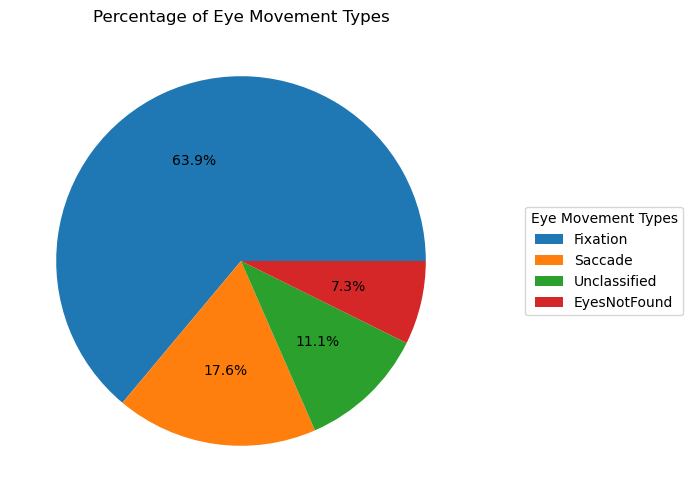

In [21]:
#let find the frequecny of eye type movement we have 
eye_movement_counts = df1['Eye movement type'].value_counts()

plt.pie(eye_movement_counts, labels=None, autopct='%1.1f%%')

plt.legend(eye_movement_counts.index, title='Eye Movement Types', loc='center left', bbox_to_anchor=(1.1, 0.5))

plt.title('Percentage of Eye Movement Types')

plt.show()


In [22]:
#finding the column name
df1.columns

Index(['Sensor', 'Participant name', 'Recording name', 'Recording duration',
       'Gaze point X', 'Gaze point Y', 'Gaze point left X',
       'Gaze point left Y', 'Gaze point right X', 'Gaze point right Y',
       'Gaze direction left X', 'Gaze direction left Y',
       'Gaze direction left Z', 'Gaze direction right X',
       'Gaze direction right Y', 'Gaze direction right Z',
       'Pupil diameter left', 'Pupil diameter right', 'Validity left',
       'Validity right', 'Eye position left X (DACSmm)',
       'Eye position left Y (DACSmm)', 'Eye position left Z (DACSmm)',
       'Eye position right X (DACSmm)', 'Eye position right Y (DACSmm)',
       'Eye position right Z (DACSmm)', 'Gaze point left X (DACSmm)',
       'Gaze point left Y (DACSmm)', 'Gaze point right X (DACSmm)',
       'Gaze point right Y (DACSmm)', 'Gaze point X (MCSnorm)',
       'Gaze point Y (MCSnorm)', 'Gaze point left X (MCSnorm)',
       'Gaze point left Y (MCSnorm)', 'Gaze point right X (MCSnorm)',
       'G

Due to the complexity of the data there are so many rows for each participants respect to each trials (i.e Recording name). We will take a median of the numerical columns to deal with the outliers 

In [23]:
# Exclude the columns ['Recording duration'] from numerical features
numerical_features = [col for col in numerical_features if col not in ['Recording duration']]

# Create a new dataframe to store the median values with participant name and recording name
median_df = pd.DataFrame(columns=['Participant name', 'Recording name'] + numerical_features)

# Group by ['Participant name'] and each ['Recording name']
grouped_df = df1.groupby(['Participant name', 'Recording name'])

# Calculate the median of each numerical column for each group
for name, group in grouped_df:
    medians = [np.median(group[col]) for col in numerical_features]
    medians.insert(0, name[0]) # Participant name
    medians.insert(1, name[1]) # Recording name
    median_df.loc[len(median_df)] = medians


median_df.head(15)


,Participant name,Recording name,Gaze point X,Gaze point Y,Gaze point left X,Gaze point left Y,Gaze point right X,Gaze point right Y,Gaze direction left X,Gaze direction left Y,...,Presented Media position X (DACSpx),Presented Media position Y (DACSpx),Original Media width,Original Media height,Gaze event duration,Eye movement type index,Fixation point X,Fixation point Y,Fixation point X (MCSnorm),Fixation point Y (MCSnorm)
0,Participant0002,Recording1,878.0,356.0,843.0,394.0,919.0,319.0,0.050580,0.110580,...,129.0,0.0,640.0,416.0,125.0,273.0,873.0,373.0,0.4496,0.3504
1,Participant0002,Recording2,930.0,319.0,896.0,346.0,968.0,284.0,0.062210,0.071070,...,129.0,0.0,640.0,416.0,150.0,38.0,921.0,316.0,0.4736,0.3110
2,Participant0002,Recording3,924.0,377.0,893.0,421.0,958.0,340.0,0.068830,0.136680,...,0.0,0.0,1920.0,1080.0,233.0,37.0,929.0,369.0,0.4811,0.3715
3,Participant0002,Recording5,866.0,362.0,826.0,405.0,909.0,325.0,0.061560,0.105640,...,0.0,0.0,1920.0,1080.0,92.0,470.0,889.0,378.0,0.4637,0.4071
4,Participant0024,Recording1,965.0,188.0,866.0,192.0,998.0,189.0,0.022070,0.130420,...,129.0,0.0,640.0,416.0,108.0,188.0,958.0,220.0,0.4892,0.2723
5,Participant0024,Recording2,1028.0,269.0,942.0,242.0,1071.0,304.0,0.076120,0.129240,...,337.0,0.0,798.0,692.0,108.0,139.0,1016.0,323.0,0.5318,0.3563
6,Participant0024,Recording3,1255.0,131.0,1218.0,126.5,1321.0,102.5,0.184855,0.082680,...,337.0,0.0,798.0,692.0,100.0,148.0,1319.0,141.0,0.6928,0.1446
7,Participant0024,Recording4,903.0,91.5,838.0,119.0,959.0,72.0,-0.005690,0.076835,...,129.0,0.0,640.0,416.0,108.0,138.0,895.0,82.0,0.4738,0.0743
8,Participant0050,Recording1,896.0,580.0,855.0,581.0,938.0,577.0,0.007310,0.138920,...,129.0,0.0,640.0,416.0,258.0,125.0,895.0,585.0,0.4610,0.5421
9,Participant0050,Recording2,857.0,476.0,806.0,494.0,904.0,466.0,-0.003290,0.097040,...,337.0,0.0,798.0,692.0,183.0,128.0,849.0,489.0,0.4112,0.4527


now we have a dataframe contain all the median values of numerical features with respect to the each participant and recording name now we do counts for the categorical features

In [24]:
df = df1.copy()
# defining the categorical features 
categorical_columns = ['Sensor', 'Validity left', 'Validity right', 'Presented Stimulus name', 'Presented Media name','Eye movement type']

# Define the features to group by
group_by_columns = ['Participant name', 'Recording name']

# making a new DataFrame to store the counts
counts_df = pd.DataFrame()

for col in categorical_columns:
    col_counts = df.groupby(group_by_columns)[col].value_counts().unstack(fill_value=0)
    col_counts.columns = [f"{col}_{val}" for val in col_counts.columns]
    counts_df = pd.concat([counts_df, col_counts], axis=1)

counts_df = counts_df.reset_index()

# Merge the counts_df DataFrame with the median_df DataFrame
final_df1 = pd.merge(median_df, counts_df, on=['Participant name', 'Recording name'])


In [25]:
final_df1.head(20)

,Participant name,Recording name,Gaze point X,Gaze point Y,Gaze point left X,Gaze point left Y,Gaze point right X,Gaze point right Y,Gaze direction left X,Gaze direction left Y,...,Presented Stimulus name_thumbnail_grossTrial,Presented Media name_Photo1.jpg,Presented Media name_Photo2.jpg,Presented Media name_Photo3.jpg,Presented Media name_babelia 6164137243739591.jpg,Presented Media name_thumbnail_grossTrial.png,Eye movement type_EyesNotFound,Eye movement type_Fixation,Eye movement type_Saccade,Eye movement type_Unclassified
0,Participant0002,Recording1,878.0,356.0,843.0,394.0,919.0,319.0,0.050580,0.110580,...,0,122,173,159,6814,0,441,4216,1665,946
1,Participant0002,Recording2,930.0,319.0,896.0,346.0,968.0,284.0,0.062210,0.071070,...,0,124,126,128,513,0,31,609,169,82
2,Participant0002,Recording3,924.0,377.0,893.0,421.0,958.0,340.0,0.068830,0.136680,...,0,122,124,127,266,0,21,514,79,25
3,Participant0002,Recording5,866.0,362.0,826.0,405.0,909.0,325.0,0.061560,0.105640,...,0,7275,5311,7303,6882,0,2147,14005,6355,4264
4,Participant0024,Recording1,965.0,188.0,866.0,192.0,998.0,189.0,0.022070,0.130420,...,0,0,0,0,10347,0,1930,4910,2095,1412
5,Participant0024,Recording2,1028.0,269.0,942.0,242.0,1071.0,304.0,0.076120,0.129240,...,7489,0,0,0,2,7489,1341,3559,1489,1102
6,Participant0024,Recording3,1255.0,131.0,1218.0,126.5,1321.0,102.5,0.184855,0.082680,...,7604,0,0,0,0,7604,363,4289,1765,1187
7,Participant0024,Recording4,903.0,91.5,838.0,119.0,959.0,72.0,-0.005690,0.076835,...,0,0,0,0,8290,0,769,4336,1911,1274
8,Participant0050,Recording1,896.0,580.0,855.0,581.0,938.0,577.0,0.007310,0.138920,...,0,0,0,2,7287,0,124,5673,1137,355
9,Participant0050,Recording2,857.0,476.0,806.0,494.0,904.0,466.0,-0.003290,0.097040,...,7169,0,0,0,0,7169,230,4922,1406,611


Now we have our final dataframe which has all the median values of numerical data and the count of categorical data now we need to add a empathy score in this datafram for making of our model

In [26]:
final_df = final_df1.copy()

In [27]:
# Define regular expression to extract numbers
pattern = re.compile(r'\d+')

# Extract numbers from strings and create new column
final_df1['Participant name'] = final_df1['Participant name'].apply(lambda x: int(pattern.search(x).group()))
final_df1 = final_df1.rename(columns={'Participant name': 'Participant no'})


# Output result
final_df1.head()


,Participant no,Recording name,Gaze point X,Gaze point Y,Gaze point left X,Gaze point left Y,Gaze point right X,Gaze point right Y,Gaze direction left X,Gaze direction left Y,...,Presented Stimulus name_thumbnail_grossTrial,Presented Media name_Photo1.jpg,Presented Media name_Photo2.jpg,Presented Media name_Photo3.jpg,Presented Media name_babelia 6164137243739591.jpg,Presented Media name_thumbnail_grossTrial.png,Eye movement type_EyesNotFound,Eye movement type_Fixation,Eye movement type_Saccade,Eye movement type_Unclassified
0,2,Recording1,878.0,356.0,843.0,394.0,919.0,319.0,0.05058,0.11058,...,0,122,173,159,6814,0,441,4216,1665,946
1,2,Recording2,930.0,319.0,896.0,346.0,968.0,284.0,0.06221,0.07107,...,0,124,126,128,513,0,31,609,169,82
2,2,Recording3,924.0,377.0,893.0,421.0,958.0,340.0,0.06883,0.13668,...,0,122,124,127,266,0,21,514,79,25
3,2,Recording5,866.0,362.0,826.0,405.0,909.0,325.0,0.06156,0.10564,...,0,7275,5311,7303,6882,0,2147,14005,6355,4264
4,24,Recording1,965.0,188.0,866.0,192.0,998.0,189.0,0.02207,0.13042,...,0,0,0,0,10347,0,1930,4910,2095,1412


Now we need to add a empathy score to our final dataframe because we have 2 questions dataset 1A and 1B and both have different empathy score we will take an average of these 2 scores and then add the average score in our final datafarme with respect to each particpant and recording(i.e trail)

In [28]:
questions1A = pd.read_csv('C:/Users/Rizwan/Desktop/DDM/empathy/data/questions/Questionnaire_datasetIA.csv', encoding= 'unicode_escape')
questions1B = pd.read_csv('C:/Users/Rizwan/Desktop/DDM/empathy/data/questions/Questionnaire_datasetIB.csv', encoding= 'unicode_escape')

# calculate the average total score extended from both files
avg_emp_scores = pd.concat([questions1A, questions1B])\
    .groupby(['Participant nr'])['Total Score extended']\
    .mean()\
    .reset_index()\
    .rename(columns={'Total Score extended': 'Avg Empathy score'})

# create a new dataframe score_df with the average total score extended
score_df = pd.merge(questions1A[['Participant nr']], avg_emp_scores, on='Participant nr', how='left')
score_df = score_df.rename(columns={'Participant nr': 'Participant no'})


In [29]:
score_df.head()

,Participant no,Avg Empathy score
0,1,135.5
1,2,130.0
2,3,119.5
3,4,117.0
4,5,131.0


Here we have got the average Empathy score with respect to each participant now will going to add this in our final dataframe

In [30]:
final_df1 = final_df1.merge(score_df, on='Participant no', how='left')

In [31]:
final_df1.head(20)

,Participant no,Recording name,Gaze point X,Gaze point Y,Gaze point left X,Gaze point left Y,Gaze point right X,Gaze point right Y,Gaze direction left X,Gaze direction left Y,...,Presented Media name_Photo1.jpg,Presented Media name_Photo2.jpg,Presented Media name_Photo3.jpg,Presented Media name_babelia 6164137243739591.jpg,Presented Media name_thumbnail_grossTrial.png,Eye movement type_EyesNotFound,Eye movement type_Fixation,Eye movement type_Saccade,Eye movement type_Unclassified,Avg Empathy score
0,2,Recording1,878.0,356.0,843.0,394.0,919.0,319.0,0.050580,0.110580,...,122,173,159,6814,0,441,4216,1665,946,130.0
1,2,Recording2,930.0,319.0,896.0,346.0,968.0,284.0,0.062210,0.071070,...,124,126,128,513,0,31,609,169,82,130.0
2,2,Recording3,924.0,377.0,893.0,421.0,958.0,340.0,0.068830,0.136680,...,122,124,127,266,0,21,514,79,25,130.0
3,2,Recording5,866.0,362.0,826.0,405.0,909.0,325.0,0.061560,0.105640,...,7275,5311,7303,6882,0,2147,14005,6355,4264,130.0
4,24,Recording1,965.0,188.0,866.0,192.0,998.0,189.0,0.022070,0.130420,...,0,0,0,10347,0,1930,4910,2095,1412,131.5
5,24,Recording2,1028.0,269.0,942.0,242.0,1071.0,304.0,0.076120,0.129240,...,0,0,0,2,7489,1341,3559,1489,1102,131.5
6,24,Recording3,1255.0,131.0,1218.0,126.5,1321.0,102.5,0.184855,0.082680,...,0,0,0,0,7604,363,4289,1765,1187,131.5
7,24,Recording4,903.0,91.5,838.0,119.0,959.0,72.0,-0.005690,0.076835,...,0,0,0,8290,0,769,4336,1911,1274,131.5
8,50,Recording1,896.0,580.0,855.0,581.0,938.0,577.0,0.007310,0.138920,...,0,0,2,7287,0,124,5673,1137,355,100.0
9,50,Recording2,857.0,476.0,806.0,494.0,904.0,466.0,-0.003290,0.097040,...,0,0,0,0,7169,230,4922,1406,611,100.0


Now we have complete one dataframe which has all the median values and counts of categorical data and also the average of the empathy score will use this dataframe to create our model

In [32]:
#saving this file to csv
final_df1.to_csv("finaldata.csv")

In [33]:
#raeding that file
finaldf1 = pd.read_csv("finaldata.csv")
finaldf1.head()

,Unnamed: 0,Participant no,Recording name,Gaze point X,Gaze point Y,Gaze point left X,Gaze point left Y,Gaze point right X,Gaze point right Y,Gaze direction left X,...,Presented Media name_Photo1.jpg,Presented Media name_Photo2.jpg,Presented Media name_Photo3.jpg,Presented Media name_babelia 6164137243739591.jpg,Presented Media name_thumbnail_grossTrial.png,Eye movement type_EyesNotFound,Eye movement type_Fixation,Eye movement type_Saccade,Eye movement type_Unclassified,Avg Empathy score
0,0,2,Recording1,878.0,356.0,843.0,394.0,919.0,319.0,0.05058,...,122,173,159,6814,0,441,4216,1665,946,130.0
1,1,2,Recording2,930.0,319.0,896.0,346.0,968.0,284.0,0.06221,...,124,126,128,513,0,31,609,169,82,130.0
2,2,2,Recording3,924.0,377.0,893.0,421.0,958.0,340.0,0.06883,...,122,124,127,266,0,21,514,79,25,130.0
3,3,2,Recording5,866.0,362.0,826.0,405.0,909.0,325.0,0.06156,...,7275,5311,7303,6882,0,2147,14005,6355,4264,130.0
4,4,24,Recording1,965.0,188.0,866.0,192.0,998.0,189.0,0.02207,...,0,0,0,10347,0,1930,4910,2095,1412,131.5


In [34]:
# removing first index
finaldf1 = finaldf1.drop(finaldf1.columns[0], axis=1)


In [35]:
finaldf1.head()

,Participant no,Recording name,Gaze point X,Gaze point Y,Gaze point left X,Gaze point left Y,Gaze point right X,Gaze point right Y,Gaze direction left X,Gaze direction left Y,...,Presented Media name_Photo1.jpg,Presented Media name_Photo2.jpg,Presented Media name_Photo3.jpg,Presented Media name_babelia 6164137243739591.jpg,Presented Media name_thumbnail_grossTrial.png,Eye movement type_EyesNotFound,Eye movement type_Fixation,Eye movement type_Saccade,Eye movement type_Unclassified,Avg Empathy score
0,2,Recording1,878.0,356.0,843.0,394.0,919.0,319.0,0.05058,0.11058,...,122,173,159,6814,0,441,4216,1665,946,130.0
1,2,Recording2,930.0,319.0,896.0,346.0,968.0,284.0,0.06221,0.07107,...,124,126,128,513,0,31,609,169,82,130.0
2,2,Recording3,924.0,377.0,893.0,421.0,958.0,340.0,0.06883,0.13668,...,122,124,127,266,0,21,514,79,25,130.0
3,2,Recording5,866.0,362.0,826.0,405.0,909.0,325.0,0.06156,0.10564,...,7275,5311,7303,6882,0,2147,14005,6355,4264,130.0
4,24,Recording1,965.0,188.0,866.0,192.0,998.0,189.0,0.02207,0.13042,...,0,0,0,10347,0,1930,4910,2095,1412,131.5


## Feature Selection

In [36]:
# Separate target variable and features
X = finaldf1.drop(['Avg Empathy score','Participant no','Recording name'], axis=1)
y = finaldf1['Avg Empathy score']

# Select top 15 features based on correlation with avg empathy score variable
selector = SelectKBest(f_regression, k=15)
X_selected = selector.fit_transform(X, y)
mask = selector.get_support() 
selected_feat = X.columns[mask] 

print("Selected Features:", selected_feat)


Selected Features: Index(['Gaze point Y', 'Gaze point left Y', 'Gaze point right Y',
       'Gaze direction left Y', 'Gaze direction right Y',
       'Eye position left X (DACSmm)', 'Eye position left Y (DACSmm)',
       'Eye position right X (DACSmm)', 'Eye position right Y (DACSmm)',
       'Gaze point left Y (DACSmm)', 'Gaze point right Y (DACSmm)',
       'Gaze point Y (MCSnorm)', 'Gaze point right Y (MCSnorm)',
       'Gaze event duration', 'Fixation point Y'],
      dtype='object')


In [37]:
X = df[selected_feat]

## Applying Regression Models

In [38]:
df = finaldf1.copy()

# Split data into training and testing sets will use selected_feat which we found before
X_train, X_test, y_train, y_test = train_test_split(df[selected_feat], df['Avg Empathy score'], test_size=0.2, random_state=42)

# making multiple regression models using cross-validation
models = {'Linear Regression': LinearRegression(),
          'Ridge Regression': Ridge(),
          'Lasso Regression': Lasso(),
          'Random Forest Regression': RandomForestRegressor()}

for name, model in models.items():
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='r2')
    print(f'{name}:')
    print(f'R-squared scores: {scores}')
    print(f'Mean R-squared score: {scores.mean():.3f}')
    print('')

# Output the best model based on cross-validation scores
best_model = max(models, key=lambda x: cross_val_score(models[x], X_train, y_train, cv=5, scoring='r2').mean())
print(f'Best model: {best_model}')


Linear Regression:
R-squared scores: [0.15154948 0.         0.29596276 0.92308079 0.38015809]
Mean R-squared score: 0.350

Ridge Regression:
R-squared scores: [0.46354633 0.         0.91240298 0.90573358 0.730469  ]
Mean R-squared score: 0.602

Lasso Regression:
R-squared scores: [0.76645641 0.         0.85679552 0.95901072 0.86078166]
Mean R-squared score: 0.689



E:\anaconda\envs\tf\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.148e+00, tolerance: 2.405e-01
  model = cd_fast.enet_coordinate_descent(
E:\anaconda\envs\tf\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.754e+00, tolerance: 2.984e-01
  model = cd_fast.enet_coordinate_descent(
E:\anaconda\envs\tf\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.376e+00, tolerance: 2.824e-01
  

Random Forest Regression:
R-squared scores: [0.81908853 0.         0.80751417 0.29203562 0.89920249]
Mean R-squared score: 0.564



E:\anaconda\envs\tf\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.148e+00, tolerance: 2.405e-01
  model = cd_fast.enet_coordinate_descent(
E:\anaconda\envs\tf\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.754e+00, tolerance: 2.984e-01
  model = cd_fast.enet_coordinate_descent(
E:\anaconda\envs\tf\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.376e+00, tolerance: 2.824e-01
  

Best model: Lasso Regression


with the Cross validation approach for model evaluation we got Lasso Regression as the best model with Mean R-squared score of 0.689

### Adding some more important features

Because in research paper it was mentioned that the pupil diameter is important so we will add pupil diameter faeture and also the count of fixation occur because fixation occurs the most in the eye movement

In [39]:
df = finaldf1.copy()
selected_feat1 = ['Gaze point Y', 'Gaze point left Y', 'Gaze point right Y',
       'Gaze direction left Y', 'Gaze direction right Y',
       'Eye position left X (DACSmm)', 'Eye position left Y (DACSmm)',
       'Eye position right X (DACSmm)', 'Eye position right Y (DACSmm)',
       'Gaze point left Y (DACSmm)', 'Gaze point right Y (DACSmm)',
       'Gaze point Y (MCSnorm)', 'Gaze point right Y (MCSnorm)',
       'Gaze event duration', 'Fixation point Y','Eye movement type_Fixation','Pupil diameter left', 'Pupil diameter right']


# Split data into training and testing sets will use selected_feat which we found before
X_train, X_test, y_train, y_test = train_test_split(df[selected_feat], df['Avg Empathy score'], test_size=0.2, random_state=42)

# making multiple regression models using cross-validation
models = {'Linear Regression': LinearRegression(),
          'Ridge Regression': Ridge(),
          'Lasso Regression': Lasso(),
          'Random Forest Regression': RandomForestRegressor()}

for name, model in models.items():
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='r2')
    print(f'{name}:')
    print(f'R-squared scores: {scores}')
    print(f'Mean R-squared score: {scores.mean():.3f}')
    print('')

# Output the best model based on cross-validation scores
best_model = max(models, key=lambda x: cross_val_score(models[x], X_train, y_train, cv=5, scoring='r2').mean())
print(f'Best model: {best_model}')


Linear Regression:
R-squared scores: [0.15154948 0.         0.29596276 0.92308079 0.38015809]
Mean R-squared score: 0.350

Ridge Regression:
R-squared scores: [0.46354633 0.         0.91240298 0.90573358 0.730469  ]
Mean R-squared score: 0.602

Lasso Regression:
R-squared scores: [0.76645641 0.         0.85679552 0.95901072 0.86078166]
Mean R-squared score: 0.689



E:\anaconda\envs\tf\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.148e+00, tolerance: 2.405e-01
  model = cd_fast.enet_coordinate_descent(
E:\anaconda\envs\tf\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.754e+00, tolerance: 2.984e-01
  model = cd_fast.enet_coordinate_descent(
E:\anaconda\envs\tf\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.376e+00, tolerance: 2.824e-01
  

Random Forest Regression:
R-squared scores: [0.83229424 0.         0.67041969 0.32796775 0.87776603]
Mean R-squared score: 0.542



E:\anaconda\envs\tf\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.148e+00, tolerance: 2.405e-01
  model = cd_fast.enet_coordinate_descent(
E:\anaconda\envs\tf\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.754e+00, tolerance: 2.984e-01
  model = cd_fast.enet_coordinate_descent(
E:\anaconda\envs\tf\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.376e+00, tolerance: 2.824e-01
  

Best model: Lasso Regression


After adding ['Eye movement type_Fixation','Pupil diameter left', 'Pupil diameter right'] our model and got the same Mean R-squared score: 0.68 of lasso regression

Now we are start working on Test Group 

### Importing Test Dataset

In [40]:
# first we are importing test group dataset
directory1 = 'C:/Users/Rizwan/Desktop/DDM/empathy/data/test_group'

#loading all the csv files
files_path1 = glob.glob(directory1 + "/*.csv")
all_dfss = []

for file in files_path1:
    df = pd.read_csv(file)
    all_dfss.append(df)

test_group = pd.concat(all_dfss, ignore_index=True)

print(test_group)


C:\Users\Rizwan\AppData\Local\Temp\ipykernel_8520\282932529.py:9: DtypeWarning: Columns (31,32,33,34,35,41,42,43,46,47,48,49,50,51,52,53,67,68) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)
C:\Users\Rizwan\AppData\Local\Temp\ipykernel_8520\282932529.py:9: DtypeWarning: Columns (20,21,34,35,50,51,67,68) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)


        Unnamed: 0  Recording timestamp  Computer timestamp       Sensor  \
0              628              3984327          1124956904          NaN   
1              629              3984327          1124956904          NaN   
2              630              3986762          1124959339  Eye Tracker   
3              631              3995099          1124967676  Eye Tracker   
4              632              4003454          1124976031  Eye Tracker   
...            ...                  ...                 ...          ...   
204945       36815             58756674       1834494623522          NaN   
204946       36816             58756674       1834494623522        Mouse   
204947       36817             58762792       1834494629640  Eye Tracker   
204948       36818             58771099       1834494637947  Eye Tracker   
204949       36819             58786933       1834494653781          NaN   

           Project name Export date Participant name Recording name  \
0       Particip

In [41]:
test_group.shape

(204950, 71)

we have total 211474 rows and 71 columns

In [42]:
test_group.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 204950 entries, 0 to 204949
Data columns (total 71 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   Unnamed: 0                           204950 non-null  int64  
 1   Recording timestamp                  204950 non-null  int64  
 2   Computer timestamp                   204950 non-null  int64  
 3   Sensor                               204789 non-null  object 
 4   Project name                         204950 non-null  object 
 5   Export date                          204950 non-null  object 
 6   Participant name                     204950 non-null  object 
 7   Recording name                       204950 non-null  object 
 8   Recording date                       204950 non-null  object 
 9   Recording date UTC                   204950 non-null  object 
 10  Recording start time                 204950 non-null  object 
 11  Recording sta

In [43]:
test_group.describe()

,Unnamed: 0,Recording timestamp,Computer timestamp,Recording duration,Recording resolution height,Recording resolution width,Eyetracker timestamp,Gaze point X,Gaze point Y,Gaze point left X,...,Presented Media position X (DACSpx),Presented Media position Y (DACSpx),Original Media width,Original Media height,Gaze event duration,Eye movement type index,Fixation point X,Fixation point Y,Mouse position X,Mouse position Y
count,204950.000000,2.049500e+05,2.049500e+05,204950.000000,204950.0,204950.0,2.005000e+05,174335.000000,174335.000000,158487.000000,...,204785.0,204785.0,204785.000000,204785.000000,204928.000000,204928.000000,112774.000000,112774.000000,4289.000000,4289.000000
mean,26528.886060,5.654604e+07,7.595215e+11,104426.034760,1080.0,1920.0,1.593915e+09,944.841587,422.177532,888.531577,...,214.0,0.0,1694.676070,1226.103811,233.298373,294.179805,947.654371,443.885018,-738.540685,780.163675
std,16112.551922,3.954601e+07,8.207855e+11,47872.167688,0.0,0.0,7.772358e+08,277.175039,296.077964,278.429888,...,0.0,0.0,493.508644,357.044332,365.899467,310.835334,258.715900,289.643305,388.104634,348.889099
min,628.000000,3.504355e+06,5.120924e+08,30766.000000,1080.0,1920.0,5.098806e+08,44.000000,-216.000000,44.000000,...,214.0,0.0,897.000000,649.000000,8.000000,4.000000,201.000000,-198.000000,-1565.000000,-8.000000
25%,13455.250000,2.722240e+07,1.207027e+09,72090.000000,1080.0,1920.0,1.063697e+09,831.000000,230.000000,768.000000,...,214.0,0.0,897.000000,649.000000,42.000000,90.000000,860.000000,278.000000,-1120.000000,583.000000
50%,24686.000000,4.841099e+07,1.601528e+09,88301.000000,1080.0,1920.0,1.287257e+09,940.000000,433.000000,885.000000,...,214.0,0.0,2000.000000,1447.000000,133.000000,192.000000,938.000000,451.000000,-712.000000,906.000000
75%,37483.000000,7.519549e+07,1.654187e+12,128686.000000,1080.0,1920.0,2.185188e+09,1083.000000,661.000000,1023.000000,...,214.0,0.0,2000.000000,1447.000000,292.000000,370.000000,1056.000000,674.000000,-405.000000,1030.000000
max,65965.000000,2.094728e+08,1.834495e+12,209613.000000,1080.0,1920.0,3.151863e+09,2256.000000,2317.000000,2234.000000,...,214.0,0.0,2000.000000,1447.000000,4428.000000,1779.000000,1752.000000,999.000000,284.000000,1230.000000


In [44]:
# creating a copy of control_group dataframe
df2 = test_group.copy()

In [45]:
df2.head()

,Unnamed: 0,Recording timestamp,Computer timestamp,Sensor,Project name,Export date,Participant name,Recording name,Recording date,Recording date UTC,...,Original Media height,Eye movement type,Gaze event duration,Eye movement type index,Fixation point X,Fixation point Y,Fixation point X (MCSnorm),Fixation point Y (MCSnorm),Mouse position X,Mouse position Y
0,628,3984327,1124956904,NaN,Participant0013,25.11.2020,Participant0013,Recording1,25.11.2020,25.11.2020,...,NaN,Fixation,400.0,13.0,1027.0,338.0,"0,5449","0,3130",NaN,NaN
1,629,3984327,1124956904,NaN,Participant0013,25.11.2020,Participant0013,Recording1,25.11.2020,25.11.2020,...,NaN,Fixation,400.0,13.0,1027.0,338.0,"0,5449","0,3130",NaN,NaN
2,630,3986762,1124959339,Eye Tracker,Participant0013,25.11.2020,Participant0013,Recording1,25.11.2020,25.11.2020,...,1447.0,Fixation,400.0,13.0,1027.0,338.0,"0,5449","0,3130",NaN,NaN
3,631,3995099,1124967676,Eye Tracker,Participant0013,25.11.2020,Participant0013,Recording1,25.11.2020,25.11.2020,...,1447.0,Fixation,400.0,13.0,1027.0,338.0,"0,5449","0,3130",NaN,NaN
4,632,4003454,1124976031,Eye Tracker,Participant0013,25.11.2020,Participant0013,Recording1,25.11.2020,25.11.2020,...,1447.0,Fixation,400.0,13.0,1027.0,338.0,"0,5449","0,3130",NaN,NaN


In [46]:
## converting all the datatypes with the actual data types


# Converting these columns into datetime their unit are milisecond
ml_date_cols = ['Recording timestamp', 'Computer timestamp', 'Recording duration', 'Eyetracker timestamp']

for col in ml_date_cols:
    df2[col] = pd.to_datetime(df2[col], unit='ms')


# Converting these columns into datetime 
date_cols = ['Export date', 'Recording date', 'Recording date UTC', 'Recording start time', 'Recording start time UTC']

for col in date_cols:
    df2[col] = pd.to_datetime(df2[col])


# Converting these columns into float and replace the (,) with the decimal point (.)

split_cols = ['Gaze direction left X','Gaze direction left Y','Gaze direction left Z','Gaze direction right X','Gaze direction right Y','Gaze direction right Z',
           'Pupil diameter left','Pupil diameter right','Eye position left X (DACSmm)','Eye position left Y (DACSmm)','Eye position left Z (DACSmm)',
           'Eye position right X (DACSmm)','Eye position right Y (DACSmm)','Eye position right Z (DACSmm)','Gaze point left X (DACSmm)',
           'Gaze point left Y (DACSmm)','Gaze point right X (DACSmm)','Gaze point right Y (DACSmm)','Gaze point X (MCSnorm)','Gaze point Y (MCSnorm)',
           'Gaze point left X (MCSnorm)','Gaze point left Y (MCSnorm)','Gaze point right X (MCSnorm)','Gaze point right Y (MCSnorm)',
           'Fixation point X (MCSnorm)','Fixation point Y (MCSnorm)'
       ]

for column in split_cols:
    df2[column] =df2[column].str.replace(',', '.').astype(float)
    

C:\Users\Rizwan\AppData\Local\Temp\ipykernel_8520\140957104.py:15: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  df2[col] = pd.to_datetime(df2[col])
C:\Users\Rizwan\AppData\Local\Temp\ipykernel_8520\140957104.py:15: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  df2[col] = pd.to_datetime(df2[col])
C:\Users\Rizwan\AppData\Local\Temp\ipykernel_8520\140957104.py:15: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  df2[col] = pd.to_datetime(df2[col])


In [47]:
df2.head()

,Unnamed: 0,Recording timestamp,Computer timestamp,Sensor,Project name,Export date,Participant name,Recording name,Recording date,Recording date UTC,...,Original Media height,Eye movement type,Gaze event duration,Eye movement type index,Fixation point X,Fixation point Y,Fixation point X (MCSnorm),Fixation point Y (MCSnorm),Mouse position X,Mouse position Y
0,628,1970-01-01 01:06:24.327,1970-01-14 00:29:16.904,NaN,Participant0013,2020-11-25,Participant0013,Recording1,2020-11-25,2020-11-25,...,NaN,Fixation,400.0,13.0,1027.0,338.0,0.5449,0.313,NaN,NaN
1,629,1970-01-01 01:06:24.327,1970-01-14 00:29:16.904,NaN,Participant0013,2020-11-25,Participant0013,Recording1,2020-11-25,2020-11-25,...,NaN,Fixation,400.0,13.0,1027.0,338.0,0.5449,0.313,NaN,NaN
2,630,1970-01-01 01:06:26.762,1970-01-14 00:29:19.339,Eye Tracker,Participant0013,2020-11-25,Participant0013,Recording1,2020-11-25,2020-11-25,...,1447.0,Fixation,400.0,13.0,1027.0,338.0,0.5449,0.313,NaN,NaN
3,631,1970-01-01 01:06:35.099,1970-01-14 00:29:27.676,Eye Tracker,Participant0013,2020-11-25,Participant0013,Recording1,2020-11-25,2020-11-25,...,1447.0,Fixation,400.0,13.0,1027.0,338.0,0.5449,0.313,NaN,NaN
4,632,1970-01-01 01:06:43.454,1970-01-14 00:29:36.031,Eye Tracker,Participant0013,2020-11-25,Participant0013,Recording1,2020-11-25,2020-11-25,...,1447.0,Fixation,400.0,13.0,1027.0,338.0,0.5449,0.313,NaN,NaN


In [48]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 204950 entries, 0 to 204949
Data columns (total 71 columns):
 #   Column                               Non-Null Count   Dtype         
---  ------                               --------------   -----         
 0   Unnamed: 0                           204950 non-null  int64         
 1   Recording timestamp                  204950 non-null  datetime64[ns]
 2   Computer timestamp                   204950 non-null  datetime64[ns]
 3   Sensor                               204789 non-null  object        
 4   Project name                         204950 non-null  object        
 5   Export date                          204950 non-null  datetime64[ns]
 6   Participant name                     204950 non-null  object        
 7   Recording name                       204950 non-null  object        
 8   Recording date                       204950 non-null  datetime64[ns]
 9   Recording date UTC                   204950 non-null  datetime64[ns]
 

all data types are converted to their respective data Because this is the tie series dataset so we need to set the index to Recording timestamp

In [49]:
# Set the index to Recording timestamp because this is the time series dataset
df2.set_index('Recording timestamp', inplace=True)

In [50]:
df2.head()

,Unnamed: 0,Computer timestamp,Sensor,Project name,Export date,Participant name,Recording name,Recording date,Recording date UTC,Recording start time,...,Original Media height,Eye movement type,Gaze event duration,Eye movement type index,Fixation point X,Fixation point Y,Fixation point X (MCSnorm),Fixation point Y (MCSnorm),Mouse position X,Mouse position Y
Recording timestamp,,,,,,,,,,,,,,,,,,,,,
1970-01-01 01:06:24.327,628,1970-01-14 00:29:16.904,NaN,Participant0013,2020-11-25,Participant0013,Recording1,2020-11-25,2020-11-25,2023-04-24 15:21:22.360,...,NaN,Fixation,400.0,13.0,1027.0,338.0,0.5449,0.313,NaN,NaN
1970-01-01 01:06:24.327,629,1970-01-14 00:29:16.904,NaN,Participant0013,2020-11-25,Participant0013,Recording1,2020-11-25,2020-11-25,2023-04-24 15:21:22.360,...,NaN,Fixation,400.0,13.0,1027.0,338.0,0.5449,0.313,NaN,NaN
1970-01-01 01:06:26.762,630,1970-01-14 00:29:19.339,Eye Tracker,Participant0013,2020-11-25,Participant0013,Recording1,2020-11-25,2020-11-25,2023-04-24 15:21:22.360,...,1447.0,Fixation,400.0,13.0,1027.0,338.0,0.5449,0.313,NaN,NaN
1970-01-01 01:06:35.099,631,1970-01-14 00:29:27.676,Eye Tracker,Participant0013,2020-11-25,Participant0013,Recording1,2020-11-25,2020-11-25,2023-04-24 15:21:22.360,...,1447.0,Fixation,400.0,13.0,1027.0,338.0,0.5449,0.313,NaN,NaN
1970-01-01 01:06:43.454,632,1970-01-14 00:29:36.031,Eye Tracker,Participant0013,2020-11-25,Participant0013,Recording1,2020-11-25,2020-11-25,2023-04-24 15:21:22.360,...,1447.0,Fixation,400.0,13.0,1027.0,338.0,0.5449,0.313,NaN,NaN


Removing below columns I did in assigment 1 here is the link

https://github.com/rizwannathani/Data-Science-and-Decision-Making/blob/63026313a95f1bc904268c27947f3c863fec2a84/DDM%20Assignment%201.ipynb

In [51]:
#Removing these columns which has no change
df2 = df2.drop(['Project name', 'Export date','Recording date','Computer timestamp','Recording date','Recording date UTC','Recording start time'
                ,'Recording start time UTC','Timeline name','Event', 'Event value', 'Mouse position X', 'Mouse position Y','Recording Fixation filter name',
                'Recording software version', 'Recording resolution height', 'Eyetracker timestamp', 'Recording resolution width', 'Recording monitor latency','Unnamed: 0'], axis=1)
df2.head()

,Sensor,Participant name,Recording name,Recording duration,Gaze point X,Gaze point Y,Gaze point left X,Gaze point left Y,Gaze point right X,Gaze point right Y,...,Presented Media position Y (DACSpx),Original Media width,Original Media height,Eye movement type,Gaze event duration,Eye movement type index,Fixation point X,Fixation point Y,Fixation point X (MCSnorm),Fixation point Y (MCSnorm)
Recording timestamp,,,,,,,,,,,,,,,,,,,,,
1970-01-01 01:06:24.327,NaN,Participant0013,Recording1,1970-01-01 00:00:52.534,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,Fixation,400.0,13.0,1027.0,338.0,0.5449,0.313
1970-01-01 01:06:24.327,NaN,Participant0013,Recording1,1970-01-01 00:00:52.534,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,Fixation,400.0,13.0,1027.0,338.0,0.5449,0.313
1970-01-01 01:06:26.762,Eye Tracker,Participant0013,Recording1,1970-01-01 00:00:52.534,1027.0,336.0,989.0,283.0,1065.0,390.0,...,0.0,2000.0,1447.0,Fixation,400.0,13.0,1027.0,338.0,0.5449,0.313
1970-01-01 01:06:35.099,Eye Tracker,Participant0013,Recording1,1970-01-01 00:00:52.534,1032.0,338.0,992.0,284.0,1071.0,392.0,...,0.0,2000.0,1447.0,Fixation,400.0,13.0,1027.0,338.0,0.5449,0.313
1970-01-01 01:06:43.454,Eye Tracker,Participant0013,Recording1,1970-01-01 00:00:52.534,1030.0,341.0,990.0,287.0,1070.0,396.0,...,0.0,2000.0,1447.0,Fixation,400.0,13.0,1027.0,338.0,0.5449,0.313


### Finding the Nan values

In [52]:
# making a list of all the nan values which are present in out dataset
na_features = [features for features in df2.columns if df2[features].isnull().sum()>1]

for features in na_features:
    print(features, '=', np.round(df2[features].isnull().mean(),2)*100, '% Missing Values')

Sensor = 0.0 % Missing Values
Gaze point X = 15.0 % Missing Values
Gaze point Y = 15.0 % Missing Values
Gaze point left X = 23.0 % Missing Values
Gaze point left Y = 23.0 % Missing Values
Gaze point right X = 22.0 % Missing Values
Gaze point right Y = 22.0 % Missing Values
Gaze direction left X = 23.0 % Missing Values
Gaze direction left Y = 23.0 % Missing Values
Gaze direction left Z = 23.0 % Missing Values
Gaze direction right X = 22.0 % Missing Values
Gaze direction right Y = 22.0 % Missing Values
Gaze direction right Z = 22.0 % Missing Values
Pupil diameter left = 74.0 % Missing Values
Pupil diameter right = 75.0 % Missing Values
Validity left = 2.0 % Missing Values
Validity right = 2.0 % Missing Values
Eye position left X (DACSmm) = 23.0 % Missing Values
Eye position left Y (DACSmm) = 23.0 % Missing Values
Eye position left Z (DACSmm) = 23.0 % Missing Values
Eye position right X (DACSmm) = 22.0 % Missing Values
Eye position right Y (DACSmm) = 22.0 % Missing Values
Eye position rig

no features are having more than 80% nan values

In [53]:
#we are doing imputation to remove the missing data by backward and forward fill technique
df2.interpolate(method='ffill', inplace=True)
df2.interpolate(method='bfill', inplace=True)

In [54]:
# lets check again how many total missing data we have

miss_count = df2.isna().sum()
total_na = miss_count.sum()
print(f'Total NaN values: {total_na}')


Total NaN values: 0


### Finding numerical features

In [55]:
#finding the columns which are having numerical data
numerical_features = [feature for feature in df2.columns if df2[feature].dtypes !='O']

print('Number of Numerical Columns: ', len(numerical_features))

df2[numerical_features].head()

Number of Numerical Columns:  43


,Recording duration,Gaze point X,Gaze point Y,Gaze point left X,Gaze point left Y,Gaze point right X,Gaze point right Y,Gaze direction left X,Gaze direction left Y,Gaze direction left Z,...,Presented Media position X (DACSpx),Presented Media position Y (DACSpx),Original Media width,Original Media height,Gaze event duration,Eye movement type index,Fixation point X,Fixation point Y,Fixation point X (MCSnorm),Fixation point Y (MCSnorm)
Recording timestamp,,,,,,,,,,,,,,,,,,,,,
1970-01-01 01:06:24.327,1970-01-01 00:00:52.534,1027.0,336.0,989.0,283.0,1065.0,390.0,0.05035,-0.09613,-0.99409,...,214.0,0.0,2000.0,1447.0,400.0,13.0,1027.0,338.0,0.5449,0.313
1970-01-01 01:06:24.327,1970-01-01 00:00:52.534,1027.0,336.0,989.0,283.0,1065.0,390.0,0.05035,-0.09613,-0.99409,...,214.0,0.0,2000.0,1447.0,400.0,13.0,1027.0,338.0,0.5449,0.313
1970-01-01 01:06:26.762,1970-01-01 00:00:52.534,1027.0,336.0,989.0,283.0,1065.0,390.0,0.05035,-0.09613,-0.99409,...,214.0,0.0,2000.0,1447.0,400.0,13.0,1027.0,338.0,0.5449,0.313
1970-01-01 01:06:35.099,1970-01-01 00:00:52.534,1032.0,338.0,992.0,284.0,1071.0,392.0,0.05216,-0.09577,-0.99404,...,214.0,0.0,2000.0,1447.0,400.0,13.0,1027.0,338.0,0.5449,0.313
1970-01-01 01:06:43.454,1970-01-01 00:00:52.534,1030.0,341.0,990.0,287.0,1070.0,396.0,0.05082,-0.09403,-0.99427,...,214.0,0.0,2000.0,1447.0,400.0,13.0,1027.0,338.0,0.5449,0.313


### Finding categorical features

In [56]:
#finding the columns which are having non numeric data
categorical_features=[feature for feature in df2.columns if df2[feature].dtypes=='O']
categorical_features

['Sensor',
 'Participant name',
 'Recording name',
 'Validity left',
 'Validity right',
 'Presented Stimulus name',
 'Presented Media name',
 'Eye movement type']

In [57]:
df2[categorical_features].head()

,Sensor,Participant name,Recording name,Validity left,Validity right,Presented Stimulus name,Presented Media name,Eye movement type
Recording timestamp,,,,,,,,
1970-01-01 01:06:24.327,Eye Tracker,Participant0013,Recording1,Valid,Valid,103111957_1133015250388940_5990313860353693579...,103111957_1133015250388940_5990313860353693579...,Fixation
1970-01-01 01:06:24.327,Eye Tracker,Participant0013,Recording1,Valid,Valid,103111957_1133015250388940_5990313860353693579...,103111957_1133015250388940_5990313860353693579...,Fixation
1970-01-01 01:06:26.762,Eye Tracker,Participant0013,Recording1,Valid,Valid,103111957_1133015250388940_5990313860353693579...,103111957_1133015250388940_5990313860353693579...,Fixation
1970-01-01 01:06:35.099,Eye Tracker,Participant0013,Recording1,Valid,Valid,103111957_1133015250388940_5990313860353693579...,103111957_1133015250388940_5990313860353693579...,Fixation
1970-01-01 01:06:43.454,Eye Tracker,Participant0013,Recording1,Valid,Valid,103111957_1133015250388940_5990313860353693579...,103111957_1133015250388940_5990313860353693579...,Fixation


In [58]:
#finding how many categories we have in a categorical columns
for feature in categorical_features:
    print('The feature is {} and number of categories are {}'.format(feature,len(df2[feature].unique())))

The feature is Sensor and number of categories are 2
The feature is Participant name and number of categories are 5
The feature is Recording name and number of categories are 6
The feature is Validity left and number of categories are 2
The feature is Validity right and number of categories are 2
The feature is Presented Stimulus name and number of categories are 3
The feature is Presented Media name and number of categories are 3
The feature is Eye movement type and number of categories are 4


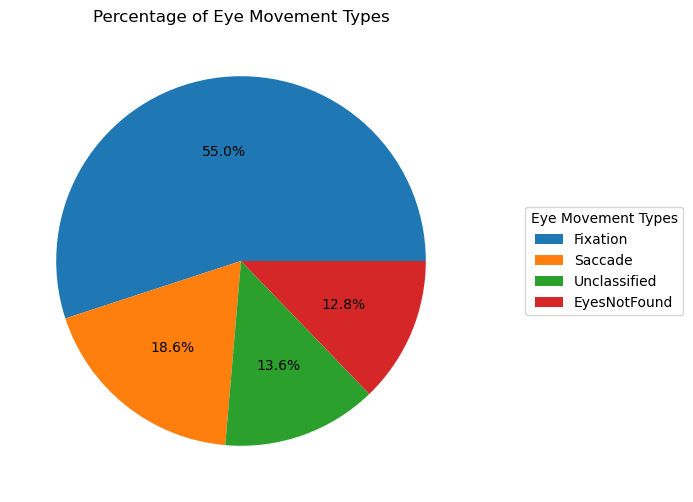

In [59]:
#let find the frequecny of eye type movement we have 
eye_movement_counts = df2['Eye movement type'].value_counts()

plt.pie(eye_movement_counts, labels=None, autopct='%1.1f%%')

plt.legend(eye_movement_counts.index, title='Eye Movement Types', loc='center left', bbox_to_anchor=(1.1, 0.5))

plt.title('Percentage of Eye Movement Types')

plt.show()


Due to the complexity of the data there are so many rows for each participants respect to each trials (i.e Recording name). We will take a median of the numerical columns to deal with the outliers

In [60]:
# Exclude the columns ['Recording duration'] from numerical features
numerical_features = [col for col in numerical_features if col not in ['Recording duration']]

# Create a new dataframe to store the median values with participant name and recording name
median_df2 = pd.DataFrame(columns=['Participant name', 'Recording name'] + numerical_features)

# Group by ['Participant name'] and each ['Recording name'] (i.e each trial)
grouped_df = df2.groupby(['Participant name', 'Recording name'])

# Calculate the median of each numerical column for each group
for name, group in grouped_df:
    medians = [np.median(group[col]) for col in numerical_features]
    medians.insert(0, name[0]) # Participant name
    medians.insert(1, name[1]) # Recording name
    median_df2.loc[len(median_df2)] = medians


median_df2.head(15)


,Participant name,Recording name,Gaze point X,Gaze point Y,Gaze point left X,Gaze point left Y,Gaze point right X,Gaze point right Y,Gaze direction left X,Gaze direction left Y,...,Presented Media position X (DACSpx),Presented Media position Y (DACSpx),Original Media width,Original Media height,Gaze event duration,Eye movement type index,Fixation point X,Fixation point Y,Fixation point X (MCSnorm),Fixation point Y (MCSnorm)
0,Participant0001,Recording1,1011.0,262.0,976.0,249.0,1045.0,272.5,0.098450,-0.023610,...,214.0,0.0,897.0,649.0,92.0,220.0,1025.0,283.0,0.5277,0.2893
1,Participant0001,Recording2,966.0,328.0,925.0,320.0,1004.0,331.0,0.085860,0.044990,...,214.0,0.0,897.0,649.0,108.0,189.0,963.0,316.0,0.5012,0.3292
2,Participant0001,Recording3,959.0,340.0,920.0,335.0,994.0,346.0,0.101860,-0.035200,...,214.0,0.0,897.0,649.0,100.0,165.0,953.0,324.0,0.5007,0.3819
3,Participant0001,Recording4,962.0,380.0,921.0,375.0,1001.0,389.0,0.088020,0.039090,...,214.0,0.0,897.0,649.0,108.0,243.0,961.0,368.0,0.5004,0.3973
4,Participant0001,Recording5,980.0,359.5,942.0,350.0,1018.0,366.0,0.088445,0.041920,...,214.0,0.0,897.0,649.0,125.0,158.0,986.0,362.0,0.5174,0.4965
5,Participant0001,Recording6,961.0,351.0,924.0,350.0,998.0,354.0,0.080700,-0.020630,...,214.0,0.0,897.0,649.0,117.0,312.0,963.0,323.0,0.4960,0.4014
6,Participant0013,Recording1,942.0,363.0,900.0,313.0,995.0,411.0,0.003760,-0.078360,...,214.0,0.0,2000.0,1447.0,258.5,75.0,948.0,360.0,0.4921,0.3336
7,Participant0013,Recording2,885.0,350.0,847.0,311.0,934.0,394.0,-0.027610,-0.082520,...,214.0,0.0,2000.0,1447.0,158.0,139.0,904.0,351.0,0.4623,0.3248
8,Participant0013,Recording3,930.0,405.0,885.0,367.0,981.0,451.0,-0.007575,-0.054490,...,214.0,0.0,2000.0,1447.0,175.0,194.0,938.0,416.0,0.4845,0.3852
9,Participant0013,Recording4,924.0,444.0,875.0,407.0,975.0,492.0,-0.014270,-0.032530,...,214.0,0.0,2000.0,1447.0,158.0,347.0,925.0,446.0,0.4767,0.4193


now we have a dataframe contain all the median values of numerical features with respect to the each participant and recording name now we do counts for the categorical features

In [61]:
df = df2.copy()
# defining the categorical features 
categorical_columns = ['Sensor', 'Validity left', 'Validity right', 'Presented Stimulus name', 'Presented Media name','Eye movement type']

# Define the features to group by
group_by_columns = ['Participant name', 'Recording name']

# making a new DataFrame to store the counts
counts_df = pd.DataFrame()

for col in categorical_columns:
    col_counts = df.groupby(group_by_columns)[col].value_counts().unstack(fill_value=0)
    col_counts.columns = [f"{col}_{val}" for val in col_counts.columns]
    counts_df = pd.concat([counts_df, col_counts], axis=1)

counts_df = counts_df.reset_index()

# Merge the counts_df DataFrame with the median_df DataFrame
final_df2 = pd.merge(median_df2, counts_df, on=['Participant name', 'Recording name'])


In [62]:
final_df2.head(20)

,Participant name,Recording name,Gaze point X,Gaze point Y,Gaze point left X,Gaze point left Y,Gaze point right X,Gaze point right Y,Gaze direction left X,Gaze direction left Y,...,Presented Stimulus name_103111957_1133015250388940_5990313860353693579_n (1),Presented Stimulus name_e-tranboard,Presented Stimulus name_e-tranboard0,Presented Media name_103111957_1133015250388940_5990313860353693579_n.jpg,Presented Media name_e-tranboard.jpg,Presented Media name_e-tranboard.png,Eye movement type_EyesNotFound,Eye movement type_Fixation,Eye movement type_Saccade,Eye movement type_Unclassified
0,Participant0001,Recording1,1011.0,262.0,976.0,249.0,1045.0,272.5,0.098450,-0.023610,...,2,0,7464,2,0,7464,395,3960,1996,1115
1,Participant0001,Recording2,966.0,328.0,925.0,320.0,1004.0,331.0,0.085860,0.044990,...,0,0,7222,0,0,7222,236,4235,1909,842
2,Participant0001,Recording3,959.0,340.0,920.0,335.0,994.0,346.0,0.101860,-0.035200,...,0,0,7219,0,0,7219,192,3987,2048,992
3,Participant0001,Recording4,962.0,380.0,921.0,375.0,1001.0,389.0,0.088020,0.039090,...,0,0,11888,0,0,11888,408,7003,3057,1420
4,Participant0001,Recording5,980.0,359.5,942.0,350.0,1018.0,366.0,0.088445,0.041920,...,0,0,7992,0,0,7992,211,4906,2068,807
5,Participant0001,Recording6,961.0,351.0,924.0,350.0,998.0,354.0,0.080700,-0.020630,...,0,0,14927,0,0,14927,666,8574,3849,1838
6,Participant0013,Recording1,942.0,363.0,900.0,313.0,995.0,411.0,0.003760,-0.078360,...,5918,0,0,5918,0,0,1825,3068,510,515
7,Participant0013,Recording2,885.0,350.0,847.0,311.0,934.0,394.0,-0.027610,-0.082520,...,8349,0,0,8349,0,0,1606,4416,1115,1212
8,Participant0013,Recording3,930.0,405.0,885.0,367.0,981.0,451.0,-0.007575,-0.054490,...,13242,0,0,13242,0,0,2394,7548,1586,1714
9,Participant0013,Recording4,924.0,444.0,875.0,407.0,975.0,492.0,-0.014270,-0.032530,...,24880,0,0,24880,0,0,4400,13589,3540,3351


Now we have our final dataframe which has all the median values of numerical data and the count of categorical data now we need to add a empathy score in this datafram for making of our model

In [63]:
# Define regular expression to extract numbers
pattern = re.compile(r'\d+')

# Extract numbers from strings and create new column
final_df2['Participant name'] = final_df2['Participant name'].apply(lambda x: int(pattern.search(x).group()))
final_df2 = final_df2.rename(columns={'Participant name': 'Participant no'})


# Output result
final_df2.head()


,Participant no,Recording name,Gaze point X,Gaze point Y,Gaze point left X,Gaze point left Y,Gaze point right X,Gaze point right Y,Gaze direction left X,Gaze direction left Y,...,Presented Stimulus name_103111957_1133015250388940_5990313860353693579_n (1),Presented Stimulus name_e-tranboard,Presented Stimulus name_e-tranboard0,Presented Media name_103111957_1133015250388940_5990313860353693579_n.jpg,Presented Media name_e-tranboard.jpg,Presented Media name_e-tranboard.png,Eye movement type_EyesNotFound,Eye movement type_Fixation,Eye movement type_Saccade,Eye movement type_Unclassified
0,1,Recording1,1011.0,262.0,976.0,249.0,1045.0,272.5,0.098450,-0.02361,...,2,0,7464,2,0,7464,395,3960,1996,1115
1,1,Recording2,966.0,328.0,925.0,320.0,1004.0,331.0,0.085860,0.04499,...,0,0,7222,0,0,7222,236,4235,1909,842
2,1,Recording3,959.0,340.0,920.0,335.0,994.0,346.0,0.101860,-0.03520,...,0,0,7219,0,0,7219,192,3987,2048,992
3,1,Recording4,962.0,380.0,921.0,375.0,1001.0,389.0,0.088020,0.03909,...,0,0,11888,0,0,11888,408,7003,3057,1420
4,1,Recording5,980.0,359.5,942.0,350.0,1018.0,366.0,0.088445,0.04192,...,0,0,7992,0,0,7992,211,4906,2068,807


In [64]:
final_df2.head(21)

,Participant no,Recording name,Gaze point X,Gaze point Y,Gaze point left X,Gaze point left Y,Gaze point right X,Gaze point right Y,Gaze direction left X,Gaze direction left Y,...,Presented Stimulus name_103111957_1133015250388940_5990313860353693579_n (1),Presented Stimulus name_e-tranboard,Presented Stimulus name_e-tranboard0,Presented Media name_103111957_1133015250388940_5990313860353693579_n.jpg,Presented Media name_e-tranboard.jpg,Presented Media name_e-tranboard.png,Eye movement type_EyesNotFound,Eye movement type_Fixation,Eye movement type_Saccade,Eye movement type_Unclassified
0,1,Recording1,1011.0,262.0,976.0,249.0,1045.0,272.5,0.098450,-0.023610,...,2,0,7464,2,0,7464,395,3960,1996,1115
1,1,Recording2,966.0,328.0,925.0,320.0,1004.0,331.0,0.085860,0.044990,...,0,0,7222,0,0,7222,236,4235,1909,842
2,1,Recording3,959.0,340.0,920.0,335.0,994.0,346.0,0.101860,-0.035200,...,0,0,7219,0,0,7219,192,3987,2048,992
3,1,Recording4,962.0,380.0,921.0,375.0,1001.0,389.0,0.088020,0.039090,...,0,0,11888,0,0,11888,408,7003,3057,1420
4,1,Recording5,980.0,359.5,942.0,350.0,1018.0,366.0,0.088445,0.041920,...,0,0,7992,0,0,7992,211,4906,2068,807
5,1,Recording6,961.0,351.0,924.0,350.0,998.0,354.0,0.080700,-0.020630,...,0,0,14927,0,0,14927,666,8574,3849,1838
6,13,Recording1,942.0,363.0,900.0,313.0,995.0,411.0,0.003760,-0.078360,...,5918,0,0,5918,0,0,1825,3068,510,515
7,13,Recording2,885.0,350.0,847.0,311.0,934.0,394.0,-0.027610,-0.082520,...,8349,0,0,8349,0,0,1606,4416,1115,1212
8,13,Recording3,930.0,405.0,885.0,367.0,981.0,451.0,-0.007575,-0.054490,...,13242,0,0,13242,0,0,2394,7548,1586,1714
9,13,Recording4,924.0,444.0,875.0,407.0,975.0,492.0,-0.014270,-0.032530,...,24880,0,0,24880,0,0,4400,13589,3540,3351


Now we need to add a empathy score to our final dataframe because we have 2 questions dataset 1A and 1B and both have different empathy score we will take an average of these 2 scores and then add the average score in our final datafarme with respect to each particpant and recording(i.e trail)

we did this above so we just merge those empathy score to corespond participant

In [65]:
final_df2 = final_df2.merge(score_df, on='Participant no', how='left')

In [66]:
final_df2.head(10)

,Participant no,Recording name,Gaze point X,Gaze point Y,Gaze point left X,Gaze point left Y,Gaze point right X,Gaze point right Y,Gaze direction left X,Gaze direction left Y,...,Presented Stimulus name_e-tranboard,Presented Stimulus name_e-tranboard0,Presented Media name_103111957_1133015250388940_5990313860353693579_n.jpg,Presented Media name_e-tranboard.jpg,Presented Media name_e-tranboard.png,Eye movement type_EyesNotFound,Eye movement type_Fixation,Eye movement type_Saccade,Eye movement type_Unclassified,Avg Empathy score
0,1,Recording1,1011.0,262.0,976.0,249.0,1045.0,272.5,0.098450,-0.02361,...,0,7464,2,0,7464,395,3960,1996,1115,135.5
1,1,Recording2,966.0,328.0,925.0,320.0,1004.0,331.0,0.085860,0.04499,...,0,7222,0,0,7222,236,4235,1909,842,135.5
2,1,Recording3,959.0,340.0,920.0,335.0,994.0,346.0,0.101860,-0.03520,...,0,7219,0,0,7219,192,3987,2048,992,135.5
3,1,Recording4,962.0,380.0,921.0,375.0,1001.0,389.0,0.088020,0.03909,...,0,11888,0,0,11888,408,7003,3057,1420,135.5
4,1,Recording5,980.0,359.5,942.0,350.0,1018.0,366.0,0.088445,0.04192,...,0,7992,0,0,7992,211,4906,2068,807,135.5
5,1,Recording6,961.0,351.0,924.0,350.0,998.0,354.0,0.080700,-0.02063,...,0,14927,0,0,14927,666,8574,3849,1838,135.5
6,13,Recording1,942.0,363.0,900.0,313.0,995.0,411.0,0.003760,-0.07836,...,0,0,5918,0,0,1825,3068,510,515,111.0
7,13,Recording2,885.0,350.0,847.0,311.0,934.0,394.0,-0.027610,-0.08252,...,0,0,8349,0,0,1606,4416,1115,1212,111.0
8,13,Recording3,930.0,405.0,885.0,367.0,981.0,451.0,-0.007575,-0.05449,...,0,0,13242,0,0,2394,7548,1586,1714,111.0
9,13,Recording4,924.0,444.0,875.0,407.0,975.0,492.0,-0.014270,-0.03253,...,0,0,24880,0,0,4400,13589,3540,3351,111.0


Now we have complete one dataframe which has all the median values and counts of categorical data and also the average of the empathy score will use this dataframe to create our model

In [67]:
#saving this file to csv
final_df2.to_csv("finaldata2.csv")

In [68]:
#reading that file
final_df2 = pd.read_csv("finaldata2.csv")
final_df2.head()

,Unnamed: 0,Participant no,Recording name,Gaze point X,Gaze point Y,Gaze point left X,Gaze point left Y,Gaze point right X,Gaze point right Y,Gaze direction left X,...,Presented Stimulus name_e-tranboard,Presented Stimulus name_e-tranboard0,Presented Media name_103111957_1133015250388940_5990313860353693579_n.jpg,Presented Media name_e-tranboard.jpg,Presented Media name_e-tranboard.png,Eye movement type_EyesNotFound,Eye movement type_Fixation,Eye movement type_Saccade,Eye movement type_Unclassified,Avg Empathy score
0,0,1,Recording1,1011.0,262.0,976.0,249.0,1045.0,272.5,0.098450,...,0,7464,2,0,7464,395,3960,1996,1115,135.5
1,1,1,Recording2,966.0,328.0,925.0,320.0,1004.0,331.0,0.085860,...,0,7222,0,0,7222,236,4235,1909,842,135.5
2,2,1,Recording3,959.0,340.0,920.0,335.0,994.0,346.0,0.101860,...,0,7219,0,0,7219,192,3987,2048,992,135.5
3,3,1,Recording4,962.0,380.0,921.0,375.0,1001.0,389.0,0.088020,...,0,11888,0,0,11888,408,7003,3057,1420,135.5
4,4,1,Recording5,980.0,359.5,942.0,350.0,1018.0,366.0,0.088445,...,0,7992,0,0,7992,211,4906,2068,807,135.5


In [69]:
# removing first index
final_df2 = final_df2.drop(final_df2.columns[0], axis=1)


In [70]:
final_df2.head()

,Participant no,Recording name,Gaze point X,Gaze point Y,Gaze point left X,Gaze point left Y,Gaze point right X,Gaze point right Y,Gaze direction left X,Gaze direction left Y,...,Presented Stimulus name_e-tranboard,Presented Stimulus name_e-tranboard0,Presented Media name_103111957_1133015250388940_5990313860353693579_n.jpg,Presented Media name_e-tranboard.jpg,Presented Media name_e-tranboard.png,Eye movement type_EyesNotFound,Eye movement type_Fixation,Eye movement type_Saccade,Eye movement type_Unclassified,Avg Empathy score
0,1,Recording1,1011.0,262.0,976.0,249.0,1045.0,272.5,0.098450,-0.02361,...,0,7464,2,0,7464,395,3960,1996,1115,135.5
1,1,Recording2,966.0,328.0,925.0,320.0,1004.0,331.0,0.085860,0.04499,...,0,7222,0,0,7222,236,4235,1909,842,135.5
2,1,Recording3,959.0,340.0,920.0,335.0,994.0,346.0,0.101860,-0.03520,...,0,7219,0,0,7219,192,3987,2048,992,135.5
3,1,Recording4,962.0,380.0,921.0,375.0,1001.0,389.0,0.088020,0.03909,...,0,11888,0,0,11888,408,7003,3057,1420,135.5
4,1,Recording5,980.0,359.5,942.0,350.0,1018.0,366.0,0.088445,0.04192,...,0,7992,0,0,7992,211,4906,2068,807,135.5


## Feature Selection

In [71]:
# Separate target variable and features
X = final_df2.drop(['Avg Empathy score','Participant no','Recording name'], axis=1)
y = final_df2['Avg Empathy score']

# Select top 15 features based on correlation with target variable
selector = SelectKBest(f_regression, k=15)
X_selected = selector.fit_transform(X, y)
mask = selector.get_support()  
selected_feat2 = X.columns[mask]  

print("Selected Features:", selected_feat2)


Selected Features: Index(['Gaze point X', 'Gaze point right X', 'Gaze point right Y',
       'Gaze direction right X', 'Eye position left X (DACSmm)',
       'Eye position right X (DACSmm)', 'Gaze point right X (DACSmm)',
       'Gaze point right Y (DACSmm)', 'Gaze point X (MCSnorm)',
       'Gaze point right X (MCSnorm)', 'Gaze event duration',
       'Fixation point X', 'Fixation point X (MCSnorm)',
       'Presented Stimulus name_103111957_1133015250388940_5990313860353693579_n (1)',
       'Presented Media name_103111957_1133015250388940_5990313860353693579_n.jpg'],
      dtype='object')


We have selected the top 5 features which are in selected_feat2 variable we use these features to make regression models

## Applying Regression Models

In [72]:
df = final_df2.copy()

# Split data into training and testing sets will use selected_feat which we found before
X_train, X_test, y_train, y_test = train_test_split(df[selected_feat2], df['Avg Empathy score'], test_size=0.2, random_state=42)

# making multiple regression models using cross-validation
models = {'Linear Regression': LinearRegression(),
          'Ridge Regression': Ridge(),
          'Lasso Regression': Lasso(),
          'Random Forest Regression': RandomForestRegressor()}

for name, model in models.items():
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='r2')
    print(f'{name}:')
    print(f'R-squared scores: {scores}')
    print(f'Mean R-squared score: {scores.mean():.3f}')
    print('')

# Output the best model based on cross-validation scores
best_model = max(models, key=lambda x: cross_val_score(models[x], X_train, y_train, cv=5, scoring='r2').mean())
print(f'Best model: {best_model}')


Linear Regression:
R-squared scores: [ 0.51999092  0.76316393 -0.53148719 -0.82114043 -0.03371216]
Mean R-squared score: -0.021

Ridge Regression:
R-squared scores: [0.84404672 0.50862786 0.73577612 0.81014577 0.03268698]
Mean R-squared score: 0.586

Lasso Regression:
R-squared scores: [0.80040665 0.5479683  0.58621239 0.93101938 0.04006809]
Mean R-squared score: 0.581

Random Forest Regression:
R-squared scores: [0.91523718 0.86261517 0.8261133  0.9044252  0.19856761]
Mean R-squared score: 0.741

Best model: Random Forest Regression


with the Cross validation approach for model evaluation we got Random Forest Regression as the best model with Mean R-squared score of 0.74

### Adding some more important features

Because in research paper it was mentioned that the pupil diameter is important so we will add pupil diameter faeture and also the count of fixation occur because fixation occurs the most in the eye movement

In [73]:
# using cross validation

df = final_df2.copy()
selected_feature = ['Gaze point X', 'Gaze point right X', 'Gaze point right Y',
       'Gaze direction right X', 'Eye position left X (DACSmm)',
       'Eye position right X (DACSmm)', 'Gaze point right X (DACSmm)',
       'Gaze point right Y (DACSmm)', 'Gaze point X (MCSnorm)',
       'Gaze point right X (MCSnorm)', 'Gaze event duration',
       'Fixation point X', 'Fixation point X (MCSnorm)',
       'Presented Stimulus name_103111957_1133015250388940_5990313860353693579_n (1)',
       'Presented Media name_103111957_1133015250388940_5990313860353693579_n.jpg',
       'Eye movement type_Fixation','Pupil diameter left', 'Pupil diameter right']

# Split data into training and testing sets will use selected_feat which we found before
X_train, X_test, y_train, y_test = train_test_split(df[selected_feature], df['Avg Empathy score'], test_size=0.2, random_state=42)

# making multiple regression models using cross-validation
models = {'Linear Regression': LinearRegression(),
          'Ridge Regression': Ridge(),
          'Lasso Regression': Lasso(),
          'Random Forest Regression': RandomForestRegressor()}

for name, model in models.items():
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='r2')
    print(f'{name}:')
    print(f'R-squared scores: {scores}')
    print(f'Mean R-squared score: {scores.mean():.3f}')
    print('')

# Output the best model based on cross-validation scores
best_model = max(models, key=lambda x: cross_val_score(models[x], X_train, y_train, cv=5, scoring='r2').mean())
print(f'Best model: {best_model}')


Linear Regression:
R-squared scores: [0.52032327 0.62559278 0.92478782 0.77628848 0.57848452]
Mean R-squared score: 0.685

Ridge Regression:
R-squared scores: [0.72689005 0.47505912 0.89596683 0.82933865 0.23670671]
Mean R-squared score: 0.633

Lasso Regression:
R-squared scores: [0.8181808  0.50837976 0.27929038 0.97188494 0.24384555]
Mean R-squared score: 0.564

Random Forest Regression:
R-squared scores: [0.9012395  0.76964414 0.7741251  0.77000776 0.27915188]
Mean R-squared score: 0.699

Best model: Random Forest Regression


After adding ['Eye movement type_Fixation','Pupil diameter left', 'Pupil diameter right'] these features we got Mean R-squared score: 0.69 of Random Forest Regression